# Data augmentation
- artificiellt skapa fler bilder
- slumpmässigt:
    - roterar till en viss grad (radianer)
    - translatera slumpmässigt
    - flippa horisontellt, vertikalt (spegla)
    - shear
    - ...

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import  load_data

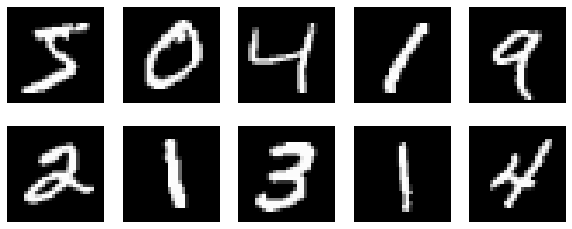

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize = (10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")

plot_samples(X_train)

In [3]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Train|val|test split

In [4]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]


X_train_val.shape

(50000, 28, 28, 1)

# Data augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_image_generator = ImageDataGenerator(
    rotation_range = 10,
    shear_range = .2,
    zoom_range = .1,
    horizontal_flip = False,
    height_shift_range = .2,
    width_shift_range = .2
)

# don't augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size = 32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size = 32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x1dd1d045790>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x1dd16bf9640>)

2
(32, 28, 28, 1)


array([0, 2, 3, 2, 1, 7, 0, 8, 9, 2, 1, 8, 0, 7, 9, 4, 8, 5, 6, 8, 0, 6,
       5, 1, 9, 7, 2, 1, 0, 3, 4, 2], dtype=uint8)

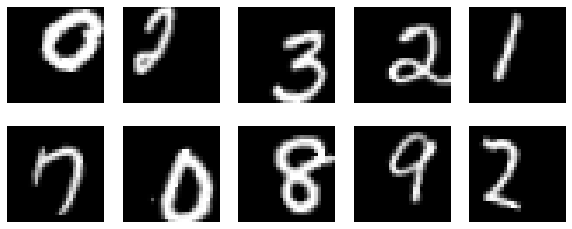

In [7]:
print(len(train_val_generator.next()))

sample_batch = train_val_generator.next()
print(sample_batch[0].shape) # 32 samples in a batch

plot_samples(sample_batch[0])
sample_batch[1]

### CNN model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [11]:
def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32, 32]):
    adam = Adam(learning_rate = learning_rate)
    
    model = Sequential(name = "CNN_model")
    
    # the convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_normal", input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPool2D(pool_size = (2, 2), strides = 2))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu",  kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax")) # output layer, 1 node per label
    
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])
    
    return model

model = CNN_model(drop_rate = .5)
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dropout_2 (Dropout)         (None, 800)               0 